# KLUE BERT를 활용한 혐오 데이터 분류 모델 만들기

train 성공하였으나 아직 분석 못함.

In [33]:
!pip install transformers[torch]
# restart the session

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.7/265.7 kB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.1/507.1 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 16.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 14.8 MB/s eta 0:00:00


In [1]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [2]:
import pandas as pd
import numpy as np
import pickle
import re
import tqdm
from google.colab import drive


In [3]:
import torch
# import datasets
import sys

In [4]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [5]:
from google.colab import drive
drive.mount('/content/drive') # 원하는 세부 경로로 변경이 불가능합니다.

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
csv_train = '/content/drive/MyDrive/data/train.tsv'
csv_test = '/content/drive/MyDrive/data/dev.tsv'

train_data = pd.read_csv(csv_train, sep='\t')
test_data = pd.read_csv(csv_test, sep='\t')


In [7]:
# 필요한 데이터인 comments와 hate 정보만 남김
train_data = train_data[['comments', 'hate']]
test_data = test_data[['comments', 'hate']]

In [8]:
# 데이터셋 갯수 확인
print('학습 데이터셋 : {}'.format(len(train_data)))
print('테스트 데이터셋 : {}'.format(len(test_data)))

학습 데이터셋 : 7896
테스트 데이터셋 : 471


In [9]:
# 데이터셋 내용 확인
train_data[:5]


,comments,hate
0,(현재 호텔주인 심정) 아18 난 마른하늘에 날벼락맞고 호텔망하게생겼는데 누군 계속...,hate
1,....한국적인 미인의 대표적인 분...너무나 곱고아름다운모습...그모습뒤의 슬픔을...,none
2,"...못된 넘들...남의 고통을 즐겼던 넘들..이젠 마땅한 처벌을 받아야지..,그래...",hate
3,"1,2화 어설펐는데 3,4화 지나서부터는 갈수록 너무 재밌던데",none
4,1. 사람 얼굴 손톱으로 긁은것은 인격살해이고2. 동영상이 몰카냐? 메걸리안들 생각...,hate


In [10]:
test_data[:5]

,comments,hate
0,송중기 시대극은 믿고본다. 첫회 신선하고 좋았다.,none
1,지현우 나쁜놈,offensive
2,알바쓰고많이만들면되지 돈욕심없으면골목식당왜나온겨 기댕기게나하고 산에가서팔어라,hate
3,설마 ㅈ 현정 작가 아니지??,hate
4,이미자씨 송혜교씨 돈이 그리 많으면 탈세말고 그돈으로 평소에 불우이웃에게 기부도 좀...,offensive


In [11]:
print(train_data['hate'].value_counts())
print(test_data['hate'].value_counts())

none         3486
offensive    2499
hate         1911
Name: hate, dtype: int64
offensive    189
none         160
hate         122
Name: hate, dtype: int64


Data pipeline for label encoder

In [12]:
from sklearn.preprocessing import LabelEncoder


In [13]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
categories = train_data['hate'].tolist()
categories1 = test_data['hate'].tolist()
le.fit(categories)
train_data['hate'] = le.transform(categories)
test_data['hate'] = le.transform(categories1)

In [14]:
train_data[:5]

,comments,hate
0,(현재 호텔주인 심정) 아18 난 마른하늘에 날벼락맞고 호텔망하게생겼는데 누군 계속...,0
1,....한국적인 미인의 대표적인 분...너무나 곱고아름다운모습...그모습뒤의 슬픔을...,1
2,"...못된 넘들...남의 고통을 즐겼던 넘들..이젠 마땅한 처벌을 받아야지..,그래...",0
3,"1,2화 어설펐는데 3,4화 지나서부터는 갈수록 너무 재밌던데",1
4,1. 사람 얼굴 손톱으로 긁은것은 인격살해이고2. 동영상이 몰카냐? 메걸리안들 생각...,0


In [15]:
test_data[:5]

,comments,hate
0,송중기 시대극은 믿고본다. 첫회 신선하고 좋았다.,1
1,지현우 나쁜놈,2
2,알바쓰고많이만들면되지 돈욕심없으면골목식당왜나온겨 기댕기게나하고 산에가서팔어라,0
3,설마 ㅈ 현정 작가 아니지??,0
4,이미자씨 송혜교씨 돈이 그리 많으면 탈세말고 그돈으로 평소에 불우이웃에게 기부도 좀...,2


In [16]:
# 데이터 중복을 제외한 갯수 확인
print("학습데이터 : ",train_data['comments'].nunique()," 라벨 : ",train_data['hate'].nunique())
print("테스트 데이터 : ",test_data['comments'].nunique()," 라벨 : ",test_data['hate'].nunique())

# 중복 데이터 제거
train_data.drop_duplicates(subset=['comments'], inplace= True)
test_data.drop_duplicates(subset=['comments'], inplace= True)

# 데이터셋 갯수 확인
print('중복 제거 후 학습 데이터셋 : {}'.format(len(train_data)))
print('중복 제거 후 테스트 데이터셋 : {}'.format(len(test_data)))

학습데이터 :  7896  라벨 :  3
테스트 데이터 :  471  라벨 :  3
중복 제거 후 학습 데이터셋 : 7896
중복 제거 후 테스트 데이터셋 : 471


In [17]:
import numpy as np

In [18]:
# null 데이터 제거
train_data['comments'].replace('', np.nan, inplace=True)
test_data['comments'].replace('', np.nan, inplace=True)
train_data = train_data.dropna(how = 'any')
test_data = test_data.dropna(how = 'any')

print('null 제거 후 학습 데이터셋 : {}'.format(len(train_data)))
print('null 제거 후 테스트 데이터셋 : {}'.format(len(test_data)))

null 제거 후 학습 데이터셋 : 7896
null 제거 후 테스트 데이터셋 : 471


In [19]:
print(train_data['comments'][0])
print(train_data['hate'][0])


(현재 호텔주인 심정) 아18 난 마른하늘에 날벼락맞고 호텔망하게생겼는데 누군 계속 추모받네....
0


학습 문장 최대 길이 : 135
학습 문장의 평균 길이 : 38.710739614994935


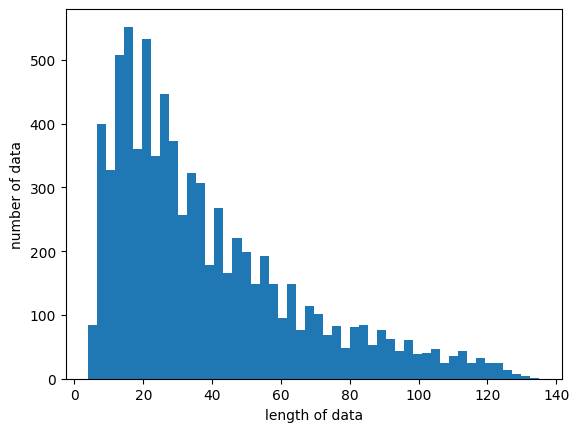

In [20]:
from matplotlib import pyplot as plt

#학습 리뷰 길이조사
print('학습 문장 최대 길이 :',max(len(l) for l in train_data['comments']))
print('학습 문장의 평균 길이 :',sum(map(len, train_data['comments']))/len(train_data['comments']))

plt.hist([len(s) for s in train_data['comments']], bins=50)
plt.xlabel('length of data')
plt.ylabel('number of data')
plt.show()

In [21]:
# Store the tokenizer we want to use
from transformers import AutoTokenizer
MODEL_NAME = "klue/bert-base"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [22]:
tokenized_train_sentences = tokenizer(
    list(train_data['comments']),
    return_tensors="pt",
    padding=True,
    truncation=True,
    add_special_tokens=True,
    )

In [23]:
print(tokenized_train_sentences[0])
print(tokenized_train_sentences[0].tokens)
print(tokenized_train_sentences[0].ids)
print(tokenized_train_sentences[0].attention_mask)

Encoding(num_tokens=82, attributes=[ids, type_ids, tokens, offsets, attention_mask, special_tokens_mask, overflowing])
['[CLS]', '(', '현재', '호텔', '##주', '##인', '심정', ')', '아', '##18', '난', '마른', '##하늘', '##에', '날', '##벼락', '##맞', '##고', '호텔', '##망', '##하', '##게', '##생', '##겼', '##는데', '누군', '계속', '추모', '##받', '##네', '.', '.', '.', '.', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]']
[2, 12, 3738, 4756, 2223, 2179, 7878, 13, 1376, 22400, 720, 10853, 13754, 2170, 721, 19023, 2608, 2088, 4756, 2087, 2205, 2318, 2065, 2484, 13964, 5280, 3851, 8212, 2757, 2203, 18, 18, 18, 18, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

In [24]:
tokenized_test_sentences = tokenizer(
    list(test_data['comments']),
    return_tensors="pt",
    padding=True,
    truncation=True,
    add_special_tokens=True,
    )

In [25]:
train_label = train_data['hate'].values
test_label = test_data['hate'].values

In [26]:
print(train_label[0])

0


In [27]:
class SingleSentDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)


In [28]:
train_dataset = SingleSentDataset(tokenized_train_sentences, train_label)
test_dataset = SingleSentDataset(tokenized_test_sentences, test_label)

In [29]:
from transformers import AutoModelForSequenceClassification, Trainer, TrainingArguments
# 문장 분류를 위해선 BERT 위에 classification을 위한 head를 부착해야 합니다.
# 해당 부분을 transformers에서는 라이브러리 하나만 호출하면 됩니다! :-)

In [30]:
training_args = TrainingArguments(
    output_dir='./results',          # output directory
    num_train_epochs=1,              # total number of training epochs
    per_device_train_batch_size=4,  # batch size per device during training
    per_device_eval_batch_size=8,   # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./logs',            # directory for storing logs
    logging_steps=500,
    save_steps=500,
    save_total_limit=2
)

In [31]:
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=3)
model.to(device, dtype=torch.float)
trainer = Trainer(
    model=model,                         # the instantiated 🤗 Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/445M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at klue/bert-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [32]:
trainer.train() # 1 epoch에 대략 30분 정도 소요됩니다 :-)

<ipython-input-27-7a16a6e720f8>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


Step,Training Loss
500,0.991400
1000,0.901200
1500,0.823000


<ipython-input-27-7a16a6e720f8>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
<ipython-input-27-7a16a6e720f8>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
<ipython-input-27-7a16a6e720f8>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


TrainOutput(global_step=1974, training_loss=0.8724445625158308, metrics={'train_runtime': 301.9841, 'train_samples_per_second': 26.147, 'train_steps_per_second': 6.537, 'total_flos': 332731583599968.0, 'train_loss': 0.8724445625158308, 'epoch': 1.0})

In [39]:
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

In [40]:
trainer = Trainer(
    model=model,
    args=training_args,
    compute_metrics=compute_metrics
)

In [41]:
trainer.evaluate(eval_dataset=test_dataset)

<ipython-input-27-7a16a6e720f8>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


{'eval_loss': 0.7589731216430664,
 'eval_accuracy': 0.6369426751592356,
 'eval_f1': 0.6266938545812002,
 'eval_precision': 0.6542445523337244,
 'eval_recall': 0.6369426751592356,
 'eval_runtime': 5.7062,
 'eval_samples_per_second': 82.542,
 'eval_steps_per_second': 10.34}

In [ ]:
# native training using torch

# model = BertForSequenceClassification.from_pretrained(MODEL_NAME)
# model.to(device)
# model.train()

# train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# optim = AdamW(model.parameters(), lr=5e-5)

# for epoch in range(3):
#     for batch in train_loader:
#         optim.zero_grad()
#         input_ids = batch['input_ids'].to(device)
#         attention_mask = batch['attention_mask'].to(device)
#         labels = batch['labels'].to(device)
#         outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
#         loss = outputs[0]
#         loss.backward()
#         optim.step()

In [42]:
# predict함수
def sentences_predict(sent):
    model.eval()
    tokenized_sent = tokenizer(
            sent,
            return_tensors="pt",
            truncation=True,
            add_special_tokens=True,
            max_length=128
    )
    tokenized_sent.to(device)

    with torch.no_grad():# 그라디엔트 계산 비활성화
        outputs = model(
            input_ids=tokenized_sent['input_ids'],
            attention_mask=tokenized_sent['attention_mask'],
            token_type_ids=tokenized_sent['token_type_ids']
            )

    logits = outputs[0]
    logits = logits.detach().cpu().numpy()
    result = np.argmax(logits)
    return result

In [43]:
print(sentences_predict("영화 개재밌어 ㅋㅋㅋㅋㅋ"))
print(sentences_predict("진짜 재미없네요 ㅋㅋ"))
print(sentences_predict("너 때문에 진짜 짜증나"))
print(sentences_predict("정말 재밌고 좋았어요."))

1
1
1
1


In [47]:
from transformers import pipeline

nlp_sentence_classif = pipeline('sentiment-analysis',model=model, tokenizer=tokenizer, device=0)

print(nlp_sentence_classif('영화 개재밌어 ㅋㅋㅋㅋㅋ'))
print(nlp_sentence_classif('진짜 재미없네요 ㅋㅋ'))
print(nlp_sentence_classif('너 때문에 진짜 짜증나'))
print(nlp_sentence_classif('정말 재밌고 좋았어요.'))

[{'label': 'LABEL_1', 'score': 0.9726364612579346}]
[{'label': 'LABEL_1', 'score': 0.9746432304382324}]
[{'label': 'LABEL_1', 'score': 0.5279151201248169}]
[{'label': 'LABEL_1', 'score': 0.9838771224021912}]


끗!